In [80]:
import findspark
findspark.init()
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflowonspark import TFCluster
from sklearn.preprocessing import MinMaxScaler

import os.path
from os import path


# Khởi tạo Spark Session
spark = SparkSession.builder.appName("kafka").getOrCreate()
sc = spark.sparkContext
# Tạo DataFrame mẫu
train_data = spark.read.csv("./train_data.csv", inferSchema=True, header=True)
test_data = spark.read.csv("./test_data.csv", inferSchema=True, header=True)

In [2]:
training_set = train_data.select("close").toPandas().values
testing_set = test_data.select("close").toPandas().values

In [21]:
print(training_set)

[[16982]
 [16982]
 [16982]
 ...
 [94655]
 [96433]
 [96166]]


In [3]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [4]:
def pre_process(data, data_scaled):
    X=[]
    y=[]
    no_of_sample = len(data)

    for i in range(60, no_of_sample):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [5]:
X_train, y_train = pre_process(training_set, training_set_scaled)

In [6]:
from prophet import Prophet

In [7]:
training = train_data.select("close", "time").toPandas().values
testing = test_data.select("close", "time").toPandas().values

In [22]:
print(training)

[[16982 datetime.date(2013, 1, 2)]
 [16982 datetime.date(2013, 1, 3)]
 [16982 datetime.date(2013, 1, 4)]
 ...
 [94655 datetime.date(2020, 12, 29)]
 [96433 datetime.date(2020, 12, 30)]
 [96166 datetime.date(2020, 12, 31)]]


In [34]:
training_scaled = training[:, 0]


[[16982 datetime.date(2013, 1, 2) 16982]
 [16982 datetime.date(2013, 1, 3) 16982]
 [16982 datetime.date(2013, 1, 4) 16982]
 ...
 [94655 datetime.date(2020, 12, 29) 94655]
 [96433 datetime.date(2020, 12, 30) 96433]
 [96166 datetime.date(2020, 12, 31) 96166]]


In [28]:
training_scaled = training_scaled.reshape(-1,1)

In [29]:
training_scaledd = scaler.fit_transform(training_scaled)

In [30]:
x_train, Y_train = pre_process(training[:,0], training_scaled)

In [35]:
trainingg = np.column_stack((training, training_set_scaled) ) 
print(trainingg)

[[16982 datetime.date(2013, 1, 2) 0.0]
 [16982 datetime.date(2013, 1, 3) 0.0]
 [16982 datetime.date(2013, 1, 4) 0.0]
 ...
 [94655 datetime.date(2020, 12, 29) 0.8168023219130545]
 [96433 datetime.date(2020, 12, 30) 0.8354996109113088]
 [96166 datetime.date(2020, 12, 31) 0.8326918627883989]]


In [41]:
print(testing)

[[95989 datetime.date(2021, 1, 4)]
 [97500 datetime.date(2021, 1, 5)]
 [97944 datetime.date(2021, 1, 6)]
 ...
 [43600 datetime.date(2023, 12, 27)]
 [44450 datetime.date(2023, 12, 28)]
 [44600 datetime.date(2023, 12, 29)]]


In [37]:
import pandas as pd
df = pd.DataFrame(trainingg)
# Đổi tên cột
df = df.rename(columns={df.columns[0]: 'yk', df.columns[1]: 'ds', df.columns[2] : 'y'})

In [42]:
df1 = pd.DataFrame(testing)
df1
# Đổi tên cột
df1 = df1.rename(columns={df1.columns[0]: 'y', df1.columns[1]: 'ds'})

In [38]:
model = Prophet()

2024-01-23 10:02:33,492 DEBUG (MainThread-15128) cmd: where.exe tbb.dll
cwd: None
2024-01-23 10:02:34,402 DEBUG (MainThread-15128) Adding TBB (D:\ANACONDA\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH


In [39]:
model.fit(df)

2024-01-23 10:02:44,495 INFO (MainThread-15128) Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-01-23 10:02:44,566 DEBUG (MainThread-15128) input tempfile: C:\Users\DELL\AppData\Local\Temp\tmpkgzft7z3\c2qx59yf.json
2024-01-23 10:02:45,019 DEBUG (MainThread-15128) input tempfile: C:\Users\DELL\AppData\Local\Temp\tmpkgzft7z3\_uiixixp.json
2024-01-23 10:02:45,024 DEBUG (MainThread-15128) idx 0
2024-01-23 10:02:45,027 DEBUG (MainThread-15128) running CmdStan, num_threads: None
2024-01-23 10:02:45,028 DEBUG (MainThread-15128) CmdStan args: ['D:\\ANACONDA\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=39821', 'data', 'file=C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpkgzft7z3\\c2qx59yf.json', 'init=C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpkgzft7z3\\_uiixixp.json', 'output', 'file=C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpkgzft7z3\\prophet_modelwam8o0rb\\prophet_model-20240123100245.csv', 'method=optimize', 'algorithm=lb

In [43]:
close_prices = model.make_future_dataframe(periods=len(df1))
forecast = model.predict(close_prices)

In [44]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,0.007151,-0.038710,0.076257,0.007151,0.007151,0.009491,0.009491,0.009491,0.001002,0.001002,0.001002,0.008488,0.008488,0.008488,0.0,0.0,0.0,0.016641
1,2013-01-03,0.007196,-0.036360,0.067204,0.007196,0.007196,0.010072,0.010072,0.010072,0.002122,0.002122,0.002122,0.007949,0.007949,0.007949,0.0,0.0,0.0,0.017267
2,2013-01-04,0.007240,-0.040235,0.071713,0.007240,0.007240,0.009278,0.009278,0.009278,0.001831,0.001831,0.001831,0.007447,0.007447,0.007447,0.0,0.0,0.0,0.016518
3,2013-01-07,0.007374,-0.037170,0.069583,0.007374,0.007374,0.007584,0.007584,0.007584,0.001437,0.001437,0.001437,0.006147,0.006147,0.006147,0.0,0.0,0.0,0.014958
4,2013-01-08,0.007419,-0.041203,0.067551,0.007419,0.007419,0.006563,0.006563,0.006563,0.000793,0.000793,0.000793,0.005770,0.005770,0.005770,0.0,0.0,0.0,0.013982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,2023-01-15,0.335202,-0.169855,0.802363,-0.157315,0.793071,-0.000058,-0.000058,-0.000058,-0.003593,-0.003593,-0.003593,0.003535,0.003535,0.003535,0.0,0.0,0.0,0.335144
2741,2023-01-16,0.334750,-0.154246,0.794310,-0.158455,0.794235,0.004600,0.004600,0.004600,0.001437,0.001437,0.001437,0.003163,0.003163,0.003163,0.0,0.0,0.0,0.339350
2742,2023-01-17,0.334298,-0.170592,0.807687,-0.159588,0.795365,0.003563,0.003563,0.003563,0.000793,0.000793,0.000793,0.002770,0.002770,0.002770,0.0,0.0,0.0,0.337861
2743,2023-01-18,0.333846,-0.163680,0.790317,-0.160684,0.795974,0.003358,0.003358,0.003358,0.001002,0.001002,0.001002,0.002356,0.002356,0.002356,0.0,0.0,0.0,0.337204


In [45]:
future = pd.DataFrame(pd.date_range(start='2021-01-04', periods=len(df1)), columns=['ds'])

In [46]:
close = future.copy()

In [47]:
forecast2 = model.predict(close)

In [48]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,0.670183,0.623900,0.735502,0.670183,0.670183,0.008885,0.008885,0.008885,0.001437,0.001437,0.001437,0.007447,0.007447,0.007447,0.0,0.0,0.0,0.679067
1,2021-01-05,0.669730,0.618948,0.736426,0.669730,0.669730,0.007774,0.007774,0.007774,0.000793,0.000793,0.000793,0.006982,0.006982,0.006982,0.0,0.0,0.0,0.677505
2,2021-01-06,0.669278,0.620233,0.731967,0.669278,0.669278,0.007552,0.007552,0.007552,0.001002,0.001002,0.001002,0.006549,0.006549,0.006549,0.0,0.0,0.0,0.676830
3,2021-01-07,0.668826,0.624280,0.733377,0.668826,0.668826,0.008269,0.008269,0.008269,0.002122,0.002122,0.002122,0.006147,0.006147,0.006147,0.0,0.0,0.0,0.677096
4,2021-01-08,0.668374,0.619983,0.727804,0.668374,0.668374,0.007601,0.007601,0.007601,0.001831,0.001831,0.001831,0.005770,0.005770,0.005770,0.0,0.0,0.0,0.675975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2023-01-18,0.333846,-0.132974,0.777275,-0.129011,0.794030,0.003358,0.003358,0.003358,0.001002,0.001002,0.001002,0.002356,0.002356,0.002356,0.0,0.0,0.0,0.337204
745,2023-01-19,0.333394,-0.125173,0.790944,-0.130415,0.794473,0.004042,0.004042,0.004042,0.002122,0.002122,0.002122,0.001919,0.001919,0.001919,0.0,0.0,0.0,0.337436
746,2023-01-20,0.332942,-0.144576,0.798774,-0.131503,0.794916,0.003293,0.003293,0.003293,0.001831,0.001831,0.001831,0.001462,0.001462,0.001462,0.0,0.0,0.0,0.336235
747,2023-01-21,0.332490,-0.142183,0.788655,-0.132056,0.795331,-0.002605,-0.002605,-0.002605,-0.003593,-0.003593,-0.003593,0.000987,0.000987,0.000987,0.0,0.0,0.0,0.329884


In [50]:
import matplotlib.pyplot as plt

In [67]:
forecast_valid = forecast2['yhat']
array = np.array(forecast_valid)
array = array.reshape(-1,1)

In [69]:
forecast_valid = scaler.inverse_transform(array)
print(forecast_valid)

[[81557.21610566]
 [81408.64348331]
 [81344.46126289]
 [81369.7387406 ]
 [81263.17077064]
 [80670.49953488]
 [80594.90362257]
 [80998.38126092]
 [80862.37254323]
 [80807.12062325]
 [80837.50998891]
 [80732.21943346]
 [80137.14905463]
 [80055.80890469]
 [80450.69600642]
 [80303.90463135]
 [80236.47003606]
 [80254.18417128]
 [80136.72154841]
 [79531.03531225]
 [79441.71199425]
 [79832.31262237]
 [79685.94612924]
 [79624.57635371]
 [79654.80227252]
 [79556.95075912]
 [78978.44298769]
 [78924.12395084]
 [79357.58365524]
 [79261.71669138]
 [79258.02206793]
 [79352.38336435]
 [79324.16872003]
 [78819.61179494]
 [78842.16297666]
 [79353.83899671]
 [79335.81704927]
 [79407.77451249]
 [79573.71336577]
 [79611.10771655]
 [79164.33434928]
 [79235.07426457]
 [79783.71201484]
 [79789.97755973]
 [79872.33039689]
 [80033.82377945]
 [80051.28625094]
 [79568.77936082]
 [79588.01864393]
 [80069.78397657]
 [79994.56355247]
 [79981.9309841 ]
 [80036.39333018]
 [79936.54751394]
 [79328.50446951]
 [79216.26

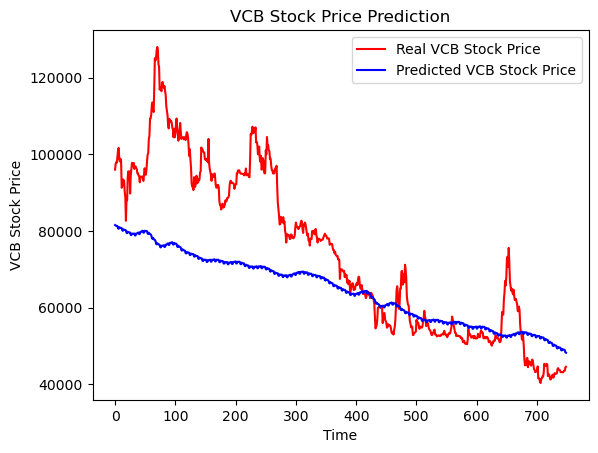

In [72]:
plt.plot(df1['y'], color = 'red', label = 'Real VCB Stock Price')
plt.plot(df1['Predictions'], color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
plt.savefig('svm_result.jpg')
plt.show()

In [58]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,0.670183,0.623900,0.735502,0.670183,0.670183,0.008885,0.008885,0.008885,0.001437,0.001437,0.001437,0.007447,0.007447,0.007447,0.0,0.0,0.0,0.679067
1,2021-01-05,0.669730,0.618948,0.736426,0.669730,0.669730,0.007774,0.007774,0.007774,0.000793,0.000793,0.000793,0.006982,0.006982,0.006982,0.0,0.0,0.0,0.677505
2,2021-01-06,0.669278,0.620233,0.731967,0.669278,0.669278,0.007552,0.007552,0.007552,0.001002,0.001002,0.001002,0.006549,0.006549,0.006549,0.0,0.0,0.0,0.676830
3,2021-01-07,0.668826,0.624280,0.733377,0.668826,0.668826,0.008269,0.008269,0.008269,0.002122,0.002122,0.002122,0.006147,0.006147,0.006147,0.0,0.0,0.0,0.677096
4,2021-01-08,0.668374,0.619983,0.727804,0.668374,0.668374,0.007601,0.007601,0.007601,0.001831,0.001831,0.001831,0.005770,0.005770,0.005770,0.0,0.0,0.0,0.675975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2023-01-18,0.333846,-0.132974,0.777275,-0.129011,0.794030,0.003358,0.003358,0.003358,0.001002,0.001002,0.001002,0.002356,0.002356,0.002356,0.0,0.0,0.0,0.337204
745,2023-01-19,0.333394,-0.125173,0.790944,-0.130415,0.794473,0.004042,0.004042,0.004042,0.002122,0.002122,0.002122,0.001919,0.001919,0.001919,0.0,0.0,0.0,0.337436
746,2023-01-20,0.332942,-0.144576,0.798774,-0.131503,0.794916,0.003293,0.003293,0.003293,0.001831,0.001831,0.001831,0.001462,0.001462,0.001462,0.0,0.0,0.0,0.336235
747,2023-01-21,0.332490,-0.142183,0.788655,-0.132056,0.795331,-0.002605,-0.002605,-0.002605,-0.003593,-0.003593,-0.003593,0.000987,0.000987,0.000987,0.0,0.0,0.0,0.329884


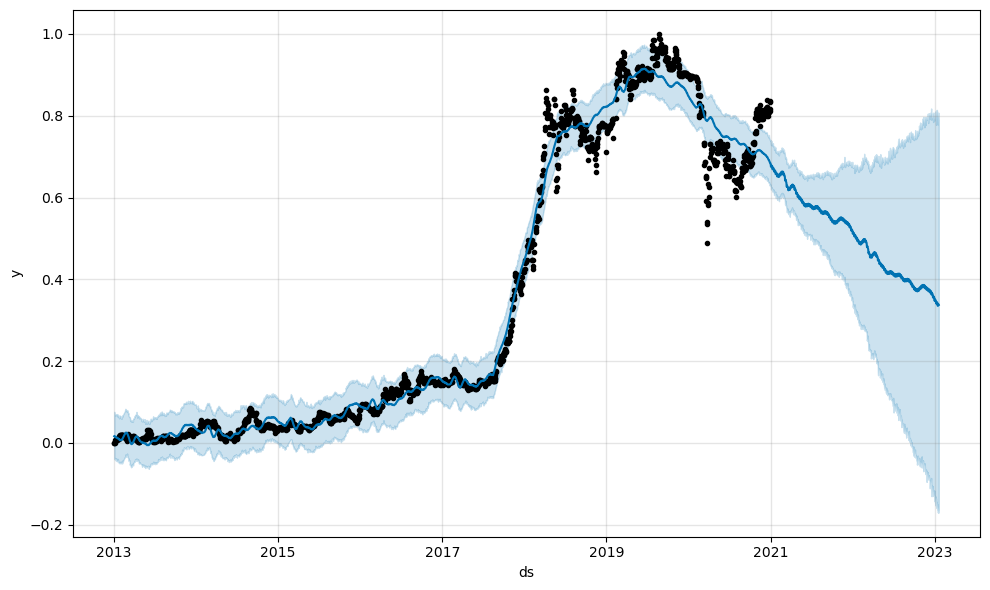

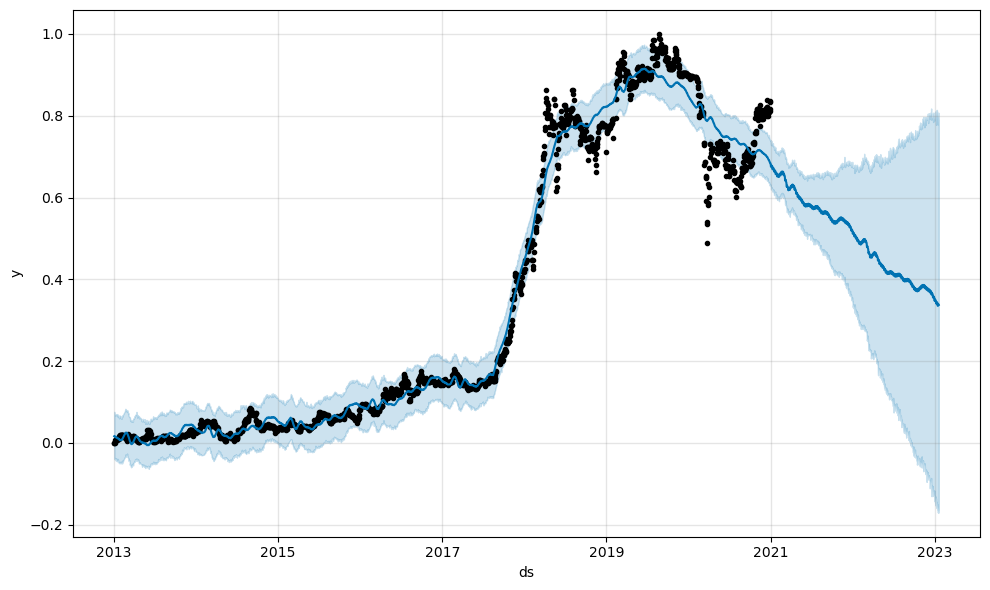

In [79]:
model.plot(forecast, uncertainty=True) 

In [77]:
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Tính toán MSE
mse = mean_squared_error(df1['y'], df1['Predictions'])

# Tính toán RMSE
rmse = np.sqrt(mse)

# Tính toán MAE
mae = mean_absolute_error(df1['y'], df1['Predictions'])

# Tính toán R^2
r2 = r2_score(df1['y'], df1['Predictions'])

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

MSE: 282153321.94275546
RMSE: 16797.420097823222
MAE: 12708.398469208329
R^2: 0.3982644078833497


Theo như đánh giá sơ bộ, mô hình này áp dụng vào có hiệu quả không quá cao trong trường hợp này, xu hướng dự đoán vẫn là một dấu hiệu đi xuống trong khi so với thực tế thì với thị trường chứng khoán có thể thay đổi bởi rất nhiều yếu tố ngoài tác động nên sẽ cần nhiều dữ liệu hơn để có thể đưa ra được những đánh giá chính xác và trực quan hơn. 